In [7]:
import os
import math
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from PIL import Image

#parametry

imside = 28
padding = 3
brush_size = 2
factor = -(2.0/brush_size)**2

root_dir = "data/Contours/"
out_dir = "data/images/"

In [8]:
def draw_pixel(img, x, y, val):
    if (x < 0 or x >= imside or y <0 or y >= imside):
        return
    if (255 - img[x][y] > val):
        img[x][y] += val
    else:
        img[x][y] = 255

def draw_dot(img, x, y):
    #draw_pixel(img, x, y, 255)
    for ox in range(-brush_size,brush_size+1):
        for oy in range(-brush_size,brush_size+1):
            draw_pixel(img, x+ox, y+oy, 20*math.exp( factor * (ox**2 + oy**2)))

In [9]:
# find the a & b points
def get_bezier_coef(points):
    # since the formulas work given that we have n+1 points
    # then n must be this:
    n = len(points) - 1

    # build coefficents matrix
    C = 4 * np.identity(n)
    np.fill_diagonal(C[1:], 1)
    np.fill_diagonal(C[:, 1:], 1)
    C[0, 0] = 2
    C[n - 1, n - 1] = 7
    C[n - 1, n - 2] = 2

    # build points vector
    P = [2 * (2 * points[i] + points[i + 1]) for i in range(n)]
    P[0] = points[0] + 2 * points[1]
    P[n - 1] = 8 * points[n - 1] + points[n]

    # solve system, find a & b
    A = np.linalg.solve(C, P)
    B = [0] * n
    for i in range(n - 1):
        B[i] = 2 * points[i + 1] - A[i + 1]
    B[n - 1] = (A[n - 1] + points[n]) / 2

    return A, B

# returns the general Bezier cubic formula given 4 control points
def get_cubic(a, b, c, d):
    return lambda t: np.power(1 - t, 3) * a + 3 * np.power(1 - t, 2) * t * b + 3 * (1 - t) * np.power(t, 2) * c + np.power(t, 3) * d

# return one cubic curve for each consecutive points
def get_bezier_cubic(points):
    A, B = get_bezier_coef(points)
    return [
        get_cubic(points[i], A[i], B[i], points[i + 1])
        for i in range(len(points) - 1)
    ]

# evalute each cubic curve on the range [0, 1] sliced in n points
def evaluate_bezier(points, n):
    curves = get_bezier_cubic(points)
    return np.array([fun(t) for fun in curves for t in np.linspace(0, 1, n)])

In [10]:
def read_dir():
    
    vectors = []
    maximum_xs = []
    maximum_ys = []
    minimum_xs = []
    minimum_ys = []
    i = 0
    
    for filename in os.listdir(directory):
        vectors.append([])
        f = open(directory + "/" + filename, "r")
        maximum_xs.append(-math.inf)
        maximum_ys.append(-math.inf)
        minimum_xs.append(math.inf)
        minimum_ys.append(math.inf)
    
        for line in f.readlines():
            line = line[:-1]
            coords = line.split(' ')
#transformacje związane z obróceniem tablicy w środowisku (powinno być trochę bardziej elegancko :?)
            vectors[i].append([float(coords[0]), -float(coords[1])])
            if (maximum_xs[i] < float(coords[0])):
                maximum_xs[i] = float(coords[0])
            if (maximum_ys[i] < -float(coords[1])):
                maximum_ys[i] = -float(coords[1])
            if (minimum_xs[i] > float(coords[0])):
                minimum_xs[i] = float(coords[0])
            if (minimum_ys[i] > -float(coords[1])):
                minimum_ys[i] = -float(coords[1])
        i = i + 1
    
    num_of_pics = i
    
    imrange = imside - 2*padding
    i = 0
    norms = []

    for v in vectors:
        range_x = maximum_xs[i] - minimum_xs[i]
        range_y = maximum_ys[i] - minimum_ys[i]

        maxrange = max(range_x , range_y)
        if maxrange == 0:
            norms.append([[imside/2, imside/2]])
            i += 1
            continue
        ratio =  min(range_x, range_y) / maxrange
    
        if (range_x > range_y):
            norms.append([[(vector[0]-minimum_xs[i])*imrange/maxrange + padding,
                            (vector[1]-minimum_ys[i])*imrange/maxrange + padding + imrange*(1-ratio)/2] for vector in v])
        else:
            norms.append([[(vector[0]-minimum_xs[i])*imrange/maxrange + padding + imrange*(1-ratio)/2,
                            (vector[1]-minimum_ys[i])*imrange/maxrange + padding] for vector in v])
        
        i = i + 1

    imgs = []

    fig = plt.figure(figsize=(30, 8*num_of_pics))
    i = 1
        
    for norm in norms:
        img = 255 * np.zeros([imside,imside], dtype=np.uint8)
    
        if (len(norm) == 1):
            draw_dot(img, int(norm[0][0]), int(norm[0][1]))
        else:    
            path = evaluate_bezier(np.array(norm), 50)
            px, py = path[:,0], path[:,1]
            n = len(px)
            for index in range(n):
                draw_dot(img, int(px[index]), int(py[index]))
            
        plot = fig.add_subplot(num_of_pics,5,i)
        plot.imshow(img,cmap='Greys')
        imgs.append(img)
        i += 1

    plt.show()

In [5]:
num_of_pics

NameError: name 'num_of_pics' is not defined

Directory 0 finished conversion.
Directory 1 finished conversion.
Directory 2 finished conversion.
Directory 3 finished conversion.
Directory 4 finished conversion.
Directory 5 finished conversion.
Directory 6 finished conversion.
Directory 7 finished conversion.
Directory 8 finished conversion.
Directory 9 finished conversion.


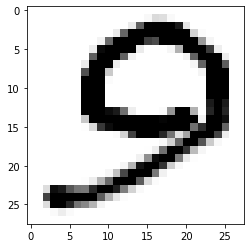

In [9]:
for dirname in os.listdir(root_dir):
    if dirname[0] == '.':
        continue
    directory = root_dir + dirname
    directory2 = out_dir + dirname
    try:
        os.makedirs(directory2)
    except FileExistsError:
        pass
    for filename in os.listdir(directory):
        out_filename = directory2 + "/" + filename
        filename = directory + "/" + filename
        f = open(filename, "r")
        
        strokes = []
        strokes.append([])
        maximum_x = (-math.inf)
        maximum_y = (-math.inf)
        minimum_x = (math.inf)
        minimum_y = (math.inf)
        
        stroke_index = 0
        for line in f.readlines():
            line = line[:-1]
            if line == '':
                strokes.append([])
                stroke_index += 1
                continue
            coords = line.split(' ')
#transformacje związane z obróceniem tablicy w środowisku (powinno być trochę bardziej elegancko :?)
            strokes[stroke_index].append([float(coords[0]), -float(coords[1])])
            if (maximum_x < float(coords[0])):
                maximum_x = float(coords[0])
            if (maximum_y < -float(coords[1])):
                maximum_y = -float(coords[1])
            if (minimum_x > float(coords[0])):
                minimum_x = float(coords[0])
            if (minimum_y > -float(coords[1])):
                minimum_y = -float(coords[1])
        
        imrange = imside - 2*padding
        
        range_x = maximum_x - minimum_x
        range_y = maximum_y - minimum_y

        maxrange = max(range_x , range_y)
        if maxrange == 0:
            normalized_strokes = [[[imside/2, imside/2]]]
        else:
            ratio =  min(range_x, range_y) / maxrange
    
            if (range_x > range_y):
                normalized_strokes = [[[(vector[0]-minimum_x)*imrange/maxrange + padding, 
                               (vector[1]-minimum_y)*imrange/maxrange + padding + imrange*(1-ratio)/2] 
                                       for vector in stroke] for stroke in strokes]
            else:
                normalized_strokes = [[[(vector[0]-minimum_x)*imrange/maxrange + padding + imrange*(1-ratio)/2,
                               (vector[1]-minimum_y)*imrange/maxrange + padding] for vector in stroke] for stroke in strokes]
        
        img = 255 * np.zeros([imside,imside], dtype=np.uint8)
    
        for normed_stroke in normalized_strokes:
            if (len(normed_stroke) == 0):
                continue
            if (len(normed_stroke) == 1):
                draw_dot(img, int(normed_stroke[0][0]), int(normed_stroke[0][1]))
            else:    
                path = evaluate_bezier(np.array(normed_stroke), 50)
                px, py = path[:,0], path[:,1]
                n = len(px)
                for index in range(n):
                    draw_dot(img, int(px[index]), int(py[index]))
            
        plt.imshow(img,cmap='Greys')
        
        im = Image.fromarray(img)
        im.save(out_filename[:-4] + ".jpg")
    print("Directory " + dirname + " finished conversion.")

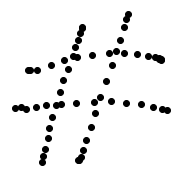

In [51]:
class_index = 82

filename = root_dir + "/" + str(class_index) + "/" + os.listdir(root_dir + str(class_index))[0]
f = open(filename, "r")
        
strokes = []
strokes.append([])
maximum_x = (-math.inf)
maximum_y = (-math.inf)
minimum_x = (math.inf)
minimum_y = (math.inf)
        
stroke_index = 0
for line in f.readlines():
    line = line[:-1]
    if line == '':
        strokes.append([])
        stroke_index += 1
        continue
    coords = line.split(' ')
#transformacje związane z obróceniem tablicy w środowisku (powinno być trochę bardziej elegancko :?)
    strokes[stroke_index].append([float(coords[0]), -float(coords[1])])
    if (maximum_x < float(coords[0])):
        maximum_x = float(coords[0])
    if (maximum_y < -float(coords[1])):
        maximum_y = -float(coords[1])
    if (minimum_x > float(coords[0])):
        minimum_x = float(coords[0])
    if (minimum_y > -float(coords[1])):
        minimum_y = -float(coords[1])
        
imrange = imside - 2*padding
    
range_x = maximum_x - minimum_x
range_y = maximum_y - minimum_y

maxrange = max(range_x , range_y)
if maxrange == 0:
    normalized_strokes = [[[imside/2, imside/2]]]
else:
    ratio =  min(range_x, range_y) / maxrange
    
    if (range_x > range_y):
        normalized_strokes = [[[(vector[0]-minimum_x)*imrange/maxrange + padding, 
                        (vector[1]-minimum_y)*imrange/maxrange + padding + imrange*(1-ratio)/2] 
                                for vector in stroke] for stroke in strokes]
    else:
        normalized_strokes = [[[(vector[0]-minimum_x)*imrange/maxrange + padding + imrange*(1-ratio)/2,
                        (vector[1]-minimum_y)*imrange/maxrange + padding] for vector in stroke] for stroke in strokes]
        
img = 255 * np.zeros([imside,imside], dtype=np.uint8)
img_points = 255 * np.ones([imside,imside], dtype=np.uint8)

plt.figure(figsize=(3, 3))
plt.axis("off")

for normed_stroke in normalized_strokes:
    if (len(normed_stroke) == 0):
        continue
    if (len(normed_stroke) == 1):
        draw_dot(img, int(normed_stroke[0][0]), int(normed_stroke[0][1]))
        img_points[int(normed_stroke[0])][int(normed_stroke[1])] = 0
    else:
        for point in normed_stroke:
            img_points[int(point[0])][int(point[1])] = 0
        points = np.array(normed_stroke)
        path = evaluate_bezier(points, 50)
        x, y = points[:,0], points[:,1]
        px, py = path[:,0], path[:,1]
        
        #plt.plot(py, -px, 'k-')
        plt.plot(y, -x, 'ko')
        
        n = len(px)
        for index in range(n):
            draw_dot(img, int(px[index]), int(py[index]))
            
plt.show()

(-0.5, 27.5, 27.5, -0.5)

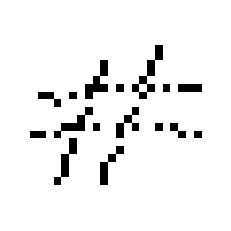

In [52]:
plt.imshow(img_points,cmap='gray')
plt.axis("off")

(-0.5, 27.5, 27.5, -0.5)

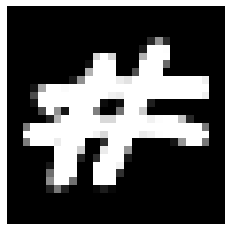

In [53]:
plt.imshow(img,cmap='gray')
plt.axis("off")